In [1]:
# ================================================
# 1. REPRODUCIBILITY SETTINGS 
# ================================================
from pathlib import Path

import random
import numpy as np
import pandas as pd
import torch

from tqdm import tqdm
import copy

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

# ----- Reproducibility -----
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# ----- Device -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ================================================
# 2. DEFAULT PATHS FOR DATASET
# ================================================
ROOT = Path("Amazon_products")   # dataset root directory

# Main corpus
TRAIN_CORPUS_PATH = ROOT / "train" /  "train_corpus.txt"       # pid \t text
TEST_CORPUS_PATH  = ROOT / "test" / "test_corpus.txt"        # pid \t text

# Taxonomy & class meta
CLASSES_PATH      = ROOT / "classes.txt"            # class_id \t class_name
HIERARCHY_PATH    = ROOT / "class_hierarchy.txt"    # parent_id \t child_id
KEYWORDS_PATH     = ROOT / "class_related_keywords.txt"

# Constants
NUM_CLASSES = 531
MIN_LABELS = 2     # minimum number of labels per sample
MAX_LABELS = 3     # maximum number of labels per sample

# Check paths
print("\n== Data path check ==")
for p in [TRAIN_CORPUS_PATH, TEST_CORPUS_PATH,
          CLASSES_PATH, HIERARCHY_PATH, KEYWORDS_PATH]:
    print(f"{p} -> {p.exists()}")

Device: cuda

== Data path check ==
Amazon_products/train/train_corpus.txt -> True
Amazon_products/test/test_corpus.txt -> True
Amazon_products/classes.txt -> True
Amazon_products/class_hierarchy.txt -> True
Amazon_products/class_related_keywords.txt -> True


In [2]:
# ================================================
# 2. DATA LOADING
# ================================================

def load_corpus(path):
    """
    Load corpus file (pid \\t text) as {pid: text} dictionary.
    """
    pid2text = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t", 1)
            if len(parts) == 2:
                pid, text = parts
                pid2text[pid] = text
    return pid2text

# Load corpus
print("Loading train/test corpus...")

pid2text_train = load_corpus(TRAIN_CORPUS_PATH)
pid2text_test  = load_corpus(TEST_CORPUS_PATH)

pid_list_train = list(pid2text_train.keys())
pid_list_test  = list(pid2text_test.keys())

print("Train samples:", len(pid2text_train))
print("Test samples :", len(pid2text_test))

# Quick sample check
for i, (pid, text) in enumerate(pid2text_train.items()):
    print(f"Example train sample #{i}: pid={pid}, text={text[:80]}...")
    break

Loading train/test corpus...
Train samples: 29487
Test samples : 19658
Example train sample #0: pid=0, text=omron hem 790it automatic blood pressure monitor with advanced omron health mana...


In [3]:
# ================================================
# 3. CLASS METADATA LOADING
# ================================================

def load_classes(path):
    """
    classes.txt : class_id \\t class_name
    returns: id2label, label2id
    """
    id2label = {}
    label2id = {}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 2:
                continue
            cid, name = parts
            cid = int(cid)
            id2label[cid] = name
            label2id[name] = cid
    return id2label, label2id


def load_hierarchy(path):
    """
    class_hierarchy.txt : parent_id \\t child_id
    returns: edges (list of tuples)
    """
    edges = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.strip().split("\t")
            if len(parts) != 2:
                continue
            p, c = map(int, parts)
            edges.append((p, c))
    return edges


def load_keywords(path, label2id):
    """
    class_related_keywords.txt : CLASS_NAME: kw1, kw2,...
    returns: {class_id: [kws]}
    """
    d = {cid: [] for cid in label2id.values()}
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if ":" not in line:
                continue
            name, kws = line.strip().split(":", 1)
            kws = [k.strip() for k in kws.split(",") if k.strip()]
            if name in label2id:
                cid = label2id[name]
                d[cid] = kws
    return d


# ----------------- Load all class meta -----------------
print("Loading class metadata...")

id2label, label2id = load_classes(CLASSES_PATH)
edges = load_hierarchy(HIERARCHY_PATH)
label_keywords = load_keywords(KEYWORDS_PATH, label2id)

print("Num classes:", len(id2label))
print("Num edges in taxonomy:", len(edges))
print()

# Small check
example_id = 0
print("Example class id:", example_id)
print("Name:", id2label[example_id])
print("Keywords:", label_keywords[example_id])

Loading class metadata...
Num classes: 531
Num edges in taxonomy: 568

Example class id: 0
Name: grocery_gourmet_food
Keywords: ['snacks', 'condiments', 'beverages', 'specialty_foods', 'spices', 'cooking_oils', 'baking_ingredients', 'gourmet_chocolates', 'artisanal_cheeses', 'organic_foods']


In [4]:
# ================================================
# 4. TEXT EMBEDDING WITH MPNet v2 (all-mpnet-base-v2)
# ================================================
from sentence_transformers import SentenceTransformer
import numpy as np
from pathlib import Path

# ----- Embedding model -----
EMB_MODEL_NAME = "sentence-transformers/all-mpnet-base-v2"

print(f"\n== Loading embedding model: {EMB_MODEL_NAME} ==")
mpnet_model = SentenceTransformer(
    EMB_MODEL_NAME,
    device=device
)

def encode_mpnet(texts, batch_size: int = 64, normalize: bool = True):
    """
    MPNet v2(all-mpnet-base-v2) 임베딩 생성 함수.
    normalize=True → cosine similarity 사용 용이.
    """
    emb = mpnet_model.encode(
        texts,
        batch_size=batch_size,
        convert_to_numpy=True,
        show_progress_bar=True,
        normalize_embeddings=normalize,
    )
    return emb


# ----- Save directory -----
EMB_DIR = ROOT / "embeddings_mpnet"
EMB_DIR.mkdir(exist_ok=True, parents=True)
print("Embedding dir:", EMB_DIR)


# ================================================
# 4-1. DOCUMENT EMBEDDINGS (TRAIN / TEST)
# ================================================
print("\n== Building MPNet document embeddings (train/test) ==")

train_texts = [pid2text_train[pid] for pid in pid_list_train]
test_texts  = [pid2text_test[pid] for pid in pid_list_test]

print("Num train texts:", len(train_texts))
print("Num test texts :", len(test_texts))

# 임베딩 계산
train_doc_mpnet = encode_mpnet(train_texts)
test_doc_mpnet  = encode_mpnet(test_texts)

print("train_doc_mpnet shape:", train_doc_mpnet.shape)
print("test_doc_mpnet shape :", test_doc_mpnet.shape)

# 저장
np.save(EMB_DIR / "train_doc_mpnet.npy", train_doc_mpnet)
np.save(EMB_DIR / "test_doc_mpnet.npy",  test_doc_mpnet)

np.save(EMB_DIR / "pid_list_train.npy", np.array(pid_list_train))
np.save(EMB_DIR / "pid_list_test.npy",  np.array(pid_list_test))


# ================================================
# 4-2. CLASS EMBEDDINGS (NAME / NAME+KEYWORDS)
# ================================================
print("\n== Building MPNet class embeddings ==")

class_ids = sorted(id2label.keys())
class_names = [id2label[cid] for cid in class_ids]

# (1) class name 임베딩
class_name_mpnet = encode_mpnet(class_names)
np.save(EMB_DIR / "class_name_mpnet.npy", class_name_mpnet)

print("class_name_mpnet shape:", class_name_mpnet.shape)

# (2) class name + keyword 텍스트
merged_class_texts = []
for cid in class_ids:
    name = id2label[cid]
    kws = label_keywords.get(cid, [])
    if kws:
        merged = name + " : " + ", ".join(kws)
    else:
        merged = name
    merged_class_texts.append(merged)

class_kw_mpnet = encode_mpnet(merged_class_texts)
np.save(EMB_DIR / "class_kw_mpnet.npy", class_kw_mpnet)

print("class_kw_mpnet shape:", class_kw_mpnet.shape)

print("\n== MPNet embedding step completed successfully. ==")

/opt/conda/envs/esci/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



== Loading embedding model: sentence-transformers/all-mpnet-base-v2 ==


/opt/conda/envs/esci/lib/python3.9/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Embedding dir: Amazon_products/embeddings_mpnet

== Building MPNet document embeddings (train/test) ==
Num train texts: 29487
Num test texts : 19658


Batches: 100%|██████████| 308/308 [01:13<00:00,  4.17it/s]


train_doc_mpnet shape: (29487, 768)
test_doc_mpnet shape : (19658, 768)

== Building MPNet class embeddings ==


Batches: 100%|██████████| 9/9 [00:00<00:00, 61.87it/s]


class_name_mpnet shape: (531, 768)


Batches: 100%|██████████| 9/9 [00:00<00:00,  9.25it/s]

class_kw_mpnet shape: (531, 768)

== MPNet embedding step completed successfully. ==


In [5]:
# ================================================
# 6. TAXONOMY UTILS (FROM edges)
# ================================================
from collections import defaultdict

class Taxonomy:
    def __init__(self, num_classes, edges):
        self.num_classes = num_classes
        self.children = defaultdict(list)
        self.parent = {cid: None for cid in range(num_classes)}

        for p, c in edges:
            self.children[p].append(c)
            self.parent[c] = p

        self.roots = [cid for cid, p in self.parent.items() if p is None]

    def get_ancestors(self, cid):
        """cid의 조상 리스트 (자기 자신 제외, root에서부터 오름차순)."""
        res = []
        cur = self.parent[cid]
        while cur is not None:
            res.append(cur)
            cur = self.parent[cur]
        return res[::-1]

    def get_path(self, cid):
        """root → ... → cid까지 path (자기 자신 포함)."""
        return self.get_ancestors(cid) + [cid]

    def get_descendants(self, cid):
        """cid 포함 모든 자손 (자기 자신 제외할지 포함할지 선택 가능)."""
        res = []
        stack = [cid]
        while stack:
            cur = stack.pop()
            for ch in self.children[cur]:
                res.append(ch)
                stack.append(ch)
        return res
        

# Taxonomy 인스턴스 생성
taxonomy = Taxonomy(NUM_CLASSES, edges)
print("Roots:", taxonomy.roots)

Roots: [0, 3, 10, 23, 40, 169]


In [6]:
# ================================================
# 7. CORE CLASS MAPPING (Taxo-style, path score 기반)
# ================================================
import numpy as np

EMB_DIR = ROOT / "embeddings"

# 7-1. 임베딩 로드
train_doc_emb = np.load(EMB_DIR / "train_doc_gte.npy")       # (N_train, dim)
test_doc_emb  = np.load(EMB_DIR / "test_doc_gte.npy")        # (N_test, dim)

# 클래스 임베딩: 우선 name 기반 사용 (원하면 class_kw_gte로 바꿔도 됨)
class_name_emb = np.load(EMB_DIR / "class_name_gte.npy")     # (NUM_CLASSES, dim)

print("train_doc_emb:", train_doc_emb.shape)
print("class_name_emb:", class_name_emb.shape)

# 7-2. cosine similarity (이미 normalize_embeddings=True 라 dot = cos)
sim_matrix = train_doc_emb @ class_name_emb.T   # (N_train, NUM_CLASSES)
print("sim_matrix:", sim_matrix.shape)


# 7-3. path score 계산
# path score(c) = path(root→...→c)에 있는 모든 노드 similarity 평균
paths = {cid: taxonomy.get_path(cid) for cid in range(NUM_CLASSES)}

path_scores = np.zeros_like(sim_matrix, dtype=np.float32)  # (N_train, NUM_CLASSES)

for cid, path in paths.items():
    # sim_matrix[:, path] : (N_train, len(path))
    vals = sim_matrix[:, path]
    path_scores[:, cid] = vals.mean(axis=1)

print("path_scores:", path_scores.shape)


# 7-4. 각 문서마다 core class 선택 (Top-k 기준)
TOP_K_CORE = 3    # TaxoClass에서 문서당 소수의 core class를 상정
MIN_SCORE  = None # 필요하면 threshold도 추가 가능

core_classes_per_doc = []
for i in range(path_scores.shape[0]):
    row = path_scores[i]
    # 점수가 높은 순으로 정렬
    idx_sorted = np.argsort(-row)  # 내림차순
    if MIN_SCORE is not None:
        idx_sorted = [cid for cid in idx_sorted if row[cid] >= MIN_SCORE]
    core = idx_sorted[:TOP_K_CORE].tolist()
    core_classes_per_doc.append(core)

print("예시 문서 0의 core classes:", core_classes_per_doc[0],
      [id2label[c] for c in core_classes_per_doc[0]])

train_doc_emb: (29487, 768)
class_name_emb: (531, 768)
sim_matrix: (29487, 531)
path_scores: (29487, 531)
예시 문서 0의 core classes: [118, 74, 317] ['health_monitors', 'medical_supplies_equipment', 'mobility_aids_equipment']


In [7]:
# ================================================
# 8. SILVER LABEL GENERATION (Taxo-style positive set)
# ================================================

def build_silver_labels(core_classes_per_doc, taxonomy, num_classes):
    """
    TaxoClass (식 7) 아이디어를 따라:
    - C_pos(i) = core classes ∪ ancestors(core)
    - negative는 BCEWithLogitsLoss에서 0으로 처리 (child-exclude는 단순화)
    """
    N = len(core_classes_per_doc)
    Y = np.zeros((N, num_classes), dtype=np.float32)

    for i, core_list in enumerate(core_classes_per_doc):
        pos = set()
        for cid in core_list:
            pos.add(cid)
            for anc in taxonomy.get_ancestors(cid):
                pos.add(anc)
        for cid in pos:
            Y[i, cid] = 1.0

    return Y

Y_silver = build_silver_labels(core_classes_per_doc, taxonomy, NUM_CLASSES)
print("Y_silver shape:", Y_silver.shape)
print("문서 0의 양성 라벨 수:", int(Y_silver[0].sum()))

Y_silver shape: (29487, 531)
문서 0의 양성 라벨 수: 4


In [8]:
# ================================================
# 9. MLP CLASSIFIER & TRAINING
# ================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# ----- Dataset -----
class EmbeddingDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0]
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


full_dataset = EmbeddingDataset(train_doc_emb, Y_silver)

# Train/valid split (pseudo label 기준이라 엄청 의미 깊진 않지만, 모니터링용)
train_size = int(0.9 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ----- MLP 모델 -----
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)


input_dim = train_doc_emb.shape[1]
hidden_dim = 512

model = MLPClassifier(input_dim, hidden_dim, NUM_CLASSES).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=531, bias=True)
  )
)


MLPClassifier(
  (net): Sequential(
    (0): Linear(in_features=768, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=531, bias=True)
  )
)
[Epoch 01] train loss = 0.1460 | valid loss = 0.0381
[Epoch 02] train loss = 0.0347 | valid loss = 0.0308
[Epoch 03] train loss = 0.0290 | valid loss = 0.0262
[Epoch 04] train loss = 0.0257 | valid loss = 0.0234
[Epoch 05] train loss = 0.0235 | valid loss = 0.0214
[Epoch 06] train loss = 0.0218 | valid loss = 0.0199
[Epoch 07] train loss = 0.0203 | valid loss = 0.0186
[Epoch 08] train loss = 0.0190 | valid loss = 0.0174
[Epoch 09] train loss = 0.0179 | valid loss = 0.0164
[Epoch 10] train loss = 0.0169 | valid loss = 0.0156


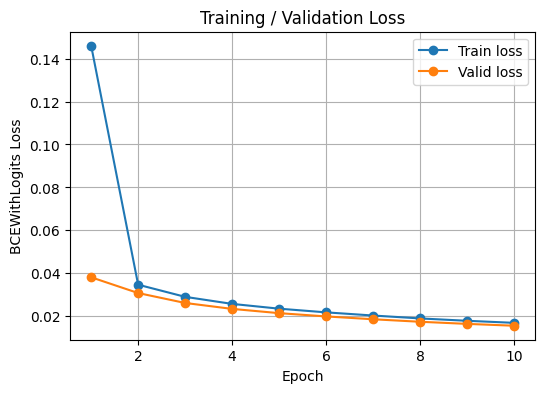

In [9]:
# ================================================
# 9. MLP CLASSIFIER & TRAINING + LOSS PLOT
# ================================================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

# ----- Dataset -----
class EmbeddingDataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        assert X.shape[0] == y.shape[0]
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


full_dataset = EmbeddingDataset(train_doc_emb, Y_silver)

# Train/valid split
train_size = int(0.9 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(full_dataset, [train_size, valid_size])

BATCH_SIZE = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)


# ----- MLP 모델 정의 -----
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_classes)
        )

    def forward(self, x):
        return self.net(x)


input_dim = train_doc_emb.shape[1]
hidden_dim = 512

model = MLPClassifier(input_dim, hidden_dim, NUM_CLASSES).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

print(model)

# ----- Training loop + loss 기록 -----
EPOCHS = 10

train_losses = []
valid_losses = []

for epoch in range(1, EPOCHS + 1):
    # --- train ---
    model.train()
    total_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        optimizer.zero_grad()
        logits = model(batch_x)
        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    avg_train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- valid ---
    model.eval()
    total_vloss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in valid_loader:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)
            loss = criterion(logits, batch_y)
            total_vloss += loss.item() * batch_x.size(0)

    avg_valid_loss = total_vloss / len(valid_loader.dataset)
    valid_losses.append(avg_valid_loss)

    print(f"[Epoch {epoch:02d}] "
          f"train loss = {avg_train_loss:.4f} | valid loss = {avg_valid_loss:.4f}")

# ----- Loss plot -----
epochs = range(1, EPOCHS + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, marker="o", label="Train loss")
plt.plot(epochs, valid_losses, marker="o", label="Valid loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogits Loss")
plt.title("Training / Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# ================================================
# 10. PREDICTION ON TEST + SUBMISSION
# ================================================
import pandas as pd

# pid 리스트 & test 임베딩
pid_list_test = np.load(EMB_DIR / "pid_list_test.npy", allow_pickle=True)

model.eval()
with torch.no_grad():
    test_x = torch.from_numpy(test_doc_emb).float().to(device)
    test_logits = model(test_x)
    test_probs = torch.sigmoid(test_logits).cpu().numpy()   # (N_test, NUM_CLASSES)

TOP_K_PRED = 3

topk_indices = np.argsort(-test_probs, axis=1)[:, :TOP_K_PRED]  # (N_test, 3)

labels_str_list = [",".join(str(int(c)) for c in row) for row in topk_indices]

submission = pd.DataFrame({
    "id": pid_list_test.astype(str),
    "labels": labels_str_list
})

SUBMISSION_PATH = ROOT / "submissions" / "mpnet_v2_taxo_mlp_top3.csv"
SUBMISSION_PATH.parent.mkdir(exist_ok=True, parents=True)
submission.to_csv(SUBMISSION_PATH, index=False, encoding="utf-8")

print("Saved submission to:", SUBMISSION_PATH)
print(submission.head())

Saved submission to: Amazon_products/submissions/mpnet_v2_taxo_mlp_top3.csv
  id     labels
0  0  10,64,473
1  1   3,17,168
2  2    3,53,30
3  3    0,8,208
4  4   10,54,11
